In [1]:
using LinearAlgebra
using Distributions
using Plots
default(label="", margin=15Plots.pt)
include("../util.jl")

e (generic function with 1 method)

In [2]:
# Beacon coordinates
β1 = [-1., 0.]
β2 = [ 1., 0.];

In [3]:
# True position
pos_true = [0., -1.]

2-element Vector{Float64}:
  0.0
 -1.0

In [4]:
function measurements(pos, β1, β2)
    
    L  = norm(β1-β2,2)
    d1 = norm(pos-β1,2)
    d2 = norm(pos-β2,2)
    
    cosα1 = (d1^2 + L^2 - d2^2)./(2*d1*L)
    cosα2 = (d2^2 + L^2 - d1^2)./(2*d2*L)
    
    return [acos(cosα1), acos(cosα2)]
end

# Angle measurements
α1, α2 = measurements(pos_true, β1, β2)

2-element Vector{Float64}:
 0.7853981633974485
 0.7853981633974485

In [5]:
function triangulation(α1,α2,β1,β2)
    
    # Distance between beacons
    L  = norm(β1-β2,2)
    
#     # Distance to beacon line
#     d = L*sin(α1)*sin(α2) ./ sin(α1 + α2)
    
#     # Distance to individual beacons
#     d1 = d ./ sin(α1)
#     d2 = d ./ sin(α2)
    
#     # Polar to cartesian conversion with respect to beacon 1
#     x = β1[1] + d1*cos(α1)
#     y = β1[2] + d1*sin(-α1)
    
    x = β1[1] + L*cos(α1)*sin(α2)./ sin(α1 + α2)
    y = β1[2] + L*sin(-α1)*sin(α2)./ sin(α1 + α2)
    
    return x,y
end

pos_est = triangulation(α1, α2, β1, β2)

(2.220446049250313e-16, -1.0000000000000004)

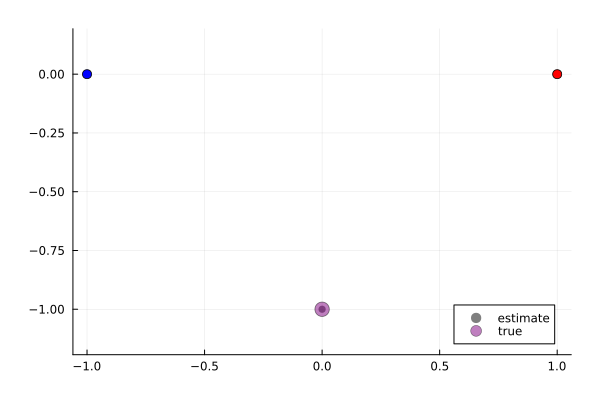

In [6]:
t = range(0.0, stop=2π, length=100)

plot(; aspect_ratio=:equal)

scatter!([β1[1]], [β1[2]], color="blue", markersize=5)
scatter!([β2[1]], [β2[2]], color="red", markersize=5)

scatter!([pos_est[1]], [pos_est[2]], label="estimate", color="black", alpha=0.5, markersize=4)

scatter!([pos_true[1]], [pos_true[2]], label="true", color="purple", alpha=0.5, markersize=8)

### Empirical variance of measurements 

In [7]:
# Compare two random points 

N = 1000
x1 = rand(MvNormal(0.5randn(2), diagm(2e-3ones(2))),N)
y1 = cat([measurements(x1[:,n], β1, β2) for n in 1:N]...,dims=2)
trc1 = det(cov(y1'))

x2 = rand(MvNormal(0.5randn(2), diagm(2e-3ones(2))),N)
y2 = cat([measurements(x2[:,n], β1, β2) for n in 1:N]...,dims=2)
trc2 = det(cov(y2'))

8.070702910047974e-5

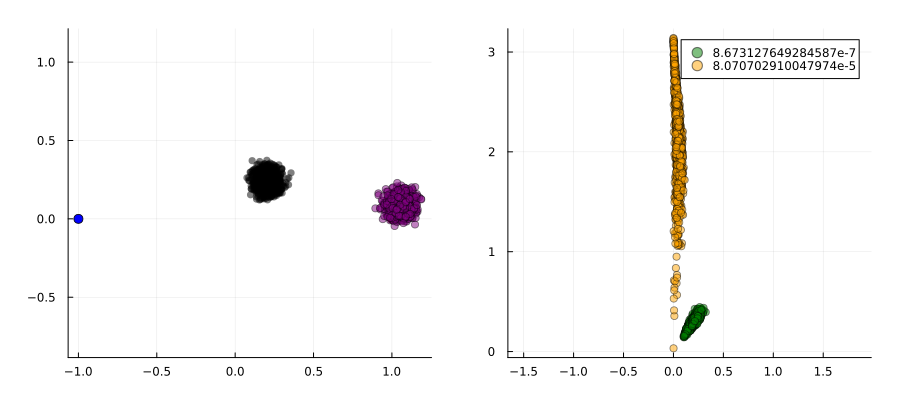

In [8]:
p101 = plot(; aspect_ratio=:equal)
scatter!([β1[1]], [β1[2]], color="blue", markersize=5)
scatter!([β2[1]], [β2[2]], color="red", markersize=5)
scatter!(x1[1,:], x1[2,:], color="black", alpha=0.5, markersize=4)
scatter!(x2[1,:], x2[2,:], color="purple", alpha=0.5, markersize=4)

p102 = plot(; aspect_ratio=:equal)
scatter!(y1[1,:], y1[2,:], color="green", label="$trc1", alpha=0.5, markersize=4)
scatter!(y2[1,:], y2[2,:], color="orange", label="$trc2", alpha=0.5, markersize=4)

plot(p101,p102, layout=grid(1,2), size=(900,400))

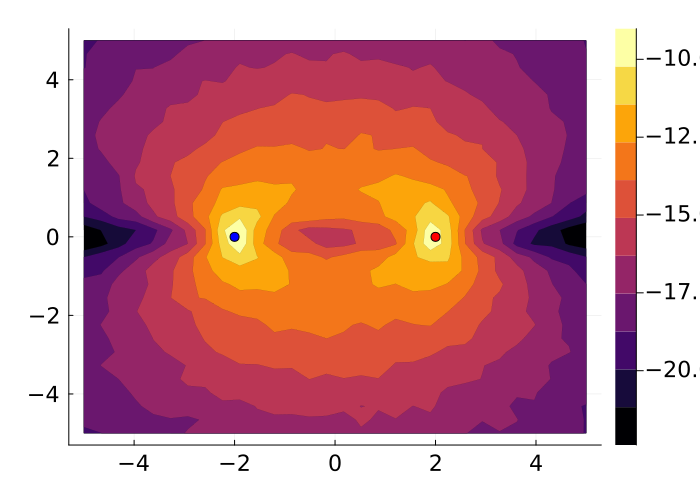

In [24]:
β1 = [-2., 0.]
β2 = [ 2., 0.]

num_samples = 100
num_grid = 30
xgrid = range(-5, 5, length=num_grid)
ygrid = range(-5, 5, length=num_grid)

S_grid = diagm(1e-2ones(2))

function helper1(x,y)
    
    state_samples = rand(MvNormal([x,y], S_grid), num_samples)
    angle_samples = cat([measurements(state_samples[:,n], β1, β2) for n in 1:num_samples]...,dims=2)
    return logdet(cov(angle_samples'))
end
    
contourf(xgrid, ygrid, helper1, levels=10, linewidth=0, tickfontsize=15, size=(700,500))
scatter!([β1[1]], [β1[2]], color="blue", markersize=5)
scatter!([β2[1]], [β2[2]], color="red", markersize=5)

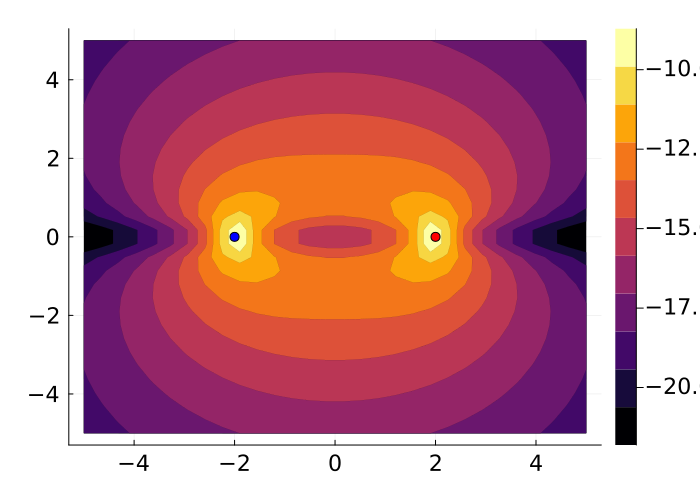

In [25]:
function helper2(x,y)
    _, Σ, _ = ET2([x,y], S_grid, a->measurements(a, β1, β2), addmatrix=diagm(1e-8ones(2)))
    return logdet(Σ)
end
    
contourf(xgrid, ygrid, helper2, levels=10, linewidth=0, tickfontsize=15, size=(700,500))
scatter!([β1[1]], [β1[2]], color="blue", markersize=5)
scatter!([β2[1]], [β2[2]], color="red", markersize=5)